# Context Size Analysis v2

This notebook measures target model loss at different context positions to understand how prediction quality varies with context length.

## Key Question
When we say "n_ctx=512", are we actually testing the model's ability to predict token at position 512?

## Important Details
- To predict token at position N, we need N tokens of context (positions 0 to N-1)
- So to predict at position 512, we need input_ids of length 513 (positions 0-512, predicting position 513)
- Due to the shift operation: `logits[:, :-1, :]` and `labels[:, 1:]`, if we have input_ids of length L, we predict L-1 tokens

Therefore: **For n_ctx=512, we're predicting positions 1 through 511 (511 predictions total)**

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pydantic")

from spd.data import DatasetConfig, create_data_loader
from spd.experiments.lm.configs import LMTaskConfig
from spd.models.component_model import ComponentModel, SPDRunInfo
from spd.utils.distributed_utils import get_device
from spd.utils.general_utils import replace_pydantic_model, set_seed
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

set_seed(0)
device = get_device()
print(f"Using device: {device}")

/mnt/polished-lake/home/braun/spd/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [2]:
# Load the run info and model
run_info = SPDRunInfo.from_path("wandb:goodfire/spd/runs/9d313yrl")
config = run_info.config
assert isinstance(config.task_config, LMTaskConfig), "task_config not LMTaskConfig"

# Load model
model = ComponentModel.from_run_info(run_info)
model.to(device)
model.target_model.requires_grad_(False)
model.eval()

print(f"Model loaded successfully")
print(f"Original max_seq_len: {config.task_config.max_seq_len}")
print(f"Dataset: {config.task_config.dataset_name}")

Model loaded successfully
Original max_seq_len: 512
Dataset: SimpleStories/SimpleStories


## Understanding the Position Calculation

When we have input_ids of shape `[batch_size, seq_len]`:
- We get logits of shape `[batch_size, seq_len, vocab_size]`
- After shift: `logits[:, :-1, :]` → shape `[batch_size, seq_len-1, vocab_size]`
- After shift: `labels[:, 1:]` → shape `[batch_size, seq_len-1]`

**This means:**
- Input length 513 → Predict 512 positions (positions 1 to 512)
- Input length 512 → Predict 511 positions (positions 1 to 511)
- Input length 800 → Predict 799 positions (positions 1 to 799)

To test predictions at specific positions, we need to be explicit about:
1. What input length we're using (n_ctx)
2. What positions we're actually making predictions for
3. Whether those positions are within the model's training range

In [3]:
def evaluate_loss_with_position_tracking(n_ctx, n_batches=10, batch_size=32):
    """
    Evaluate target model loss for a specific context size.
    
    Args:
        n_ctx: The sequence length to load from dataset
        
    Returns:
        Dictionary with:
        - mean_loss: Average loss across all predictions
        - std_loss: Standard deviation of batch losses
        - losses_per_position: Loss at each position (averaged over batches)
        - min_predicted_pos: Minimum position predicted (always 1)
        - max_predicted_pos: Maximum position predicted (n_ctx - 1)
        - num_predictions_per_batch: n_ctx - 1
    """
    set_seed(0)
    
    # Create task config with the specified context size
    task_config = replace_pydantic_model(
        config.task_config, 
        {"max_seq_len": n_ctx, "train_data_split": "train[:5000]"}
    )
    
    # Create data config
    data_config = DatasetConfig(
        name=task_config.dataset_name,
        hf_tokenizer_path=config.tokenizer_name,
        split=task_config.train_data_split,
        n_ctx=task_config.max_seq_len,
        is_tokenized=task_config.is_tokenized,
        streaming=task_config.streaming,
        column_name=task_config.column_name,
        shuffle_each_epoch=task_config.shuffle_each_epoch,
        seed=0,
    )
    
    # Create data loader
    data_loader, _tokenizer = create_data_loader(
        dataset_config=data_config,
        batch_size=batch_size,
        buffer_size=task_config.buffer_size,
        global_seed=0,
        ddp_rank=0,
        ddp_world_size=1,
    )
    
    # Collect losses per position (accumulated then averaged)
    position_losses = torch.zeros(n_ctx - 1, device=device)
    position_counts = torch.zeros(n_ctx - 1, device=device)
    batch_losses = []
    
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            if i >= n_batches:
                break
            
            input_ids = batch["input_ids"].to(device)
            actual_seq_len = input_ids.shape[1]
            
            # Verify we got the expected sequence length
            assert actual_seq_len == n_ctx, f"Expected seq_len={n_ctx}, got {actual_seq_len}"
            
            # Forward pass through target model
            output = model.target_model(input_ids)
            
            # Extract logits
            if hasattr(output, 'logits'):
                logits = output.logits
            else:
                logits = output
            
            # Calculate cross-entropy loss per position
            # Shift: logits[:, :-1, :] predicts labels[:, 1:]
            shift_logits = logits[:, :-1, :].contiguous()
            shift_labels = input_ids[:, 1:].contiguous()
            
            # Calculate loss per token (no reduction)
            loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
            per_token_loss = loss_fct(
                shift_logits.view(-1, shift_logits.size(-1)),
                shift_labels.view(-1)
            )
            
            # Reshape to [batch_size, seq_len-1]
            per_token_loss = per_token_loss.view(shift_logits.shape[0], shift_logits.shape[1])
            
            # Accumulate per-position losses
            position_losses[:actual_seq_len-1] += per_token_loss.sum(dim=0)
            position_counts[:actual_seq_len-1] += per_token_loss.shape[0]
            
            # Store batch average loss
            batch_losses.append(per_token_loss.mean().item())
    
    # Average the position losses
    avg_position_losses = (position_losses / position_counts.clamp(min=1)).cpu().numpy()
    
    return {
        'mean_loss': np.mean(batch_losses),
        'std_loss': np.std(batch_losses),
        'min_loss': np.min(batch_losses),
        'max_loss': np.max(batch_losses),
        'losses_per_position': avg_position_losses,
        'min_predicted_pos': 1,
        'max_predicted_pos': n_ctx - 1,
        'num_predictions': n_ctx - 1,
        'input_seq_len': n_ctx
    }

print("Function defined successfully")

Function defined successfully


In [4]:
# Define the context sizes to test
# NOTE: If we want to predict AT position 512, we need input_seq_len = 513
context_sizes = [8, 32, 128, 511, 512, 513, 800]

n_batches = 10
batch_size = 32

print(f"Will evaluate {n_batches} batches of size {batch_size} for each context size")
print(f"Context sizes (input sequence lengths): {context_sizes}")
print()
print("Prediction ranges:")
for n_ctx in context_sizes:
    print(f"  n_ctx={n_ctx:3d} → Predicts positions 1 to {n_ctx-1:3d} ({n_ctx-1:3d} predictions)")

Will evaluate 10 batches of size 32 for each context size
Context sizes (input sequence lengths): [8, 32, 128, 511, 512, 513, 800]

Prediction ranges:
  n_ctx=  8 → Predicts positions 1 to   7 (  7 predictions)
  n_ctx= 32 → Predicts positions 1 to  31 ( 31 predictions)
  n_ctx=128 → Predicts positions 1 to 127 (127 predictions)
  n_ctx=511 → Predicts positions 1 to 510 (510 predictions)
  n_ctx=512 → Predicts positions 1 to 511 (511 predictions)
  n_ctx=513 → Predicts positions 1 to 512 (512 predictions)
  n_ctx=800 → Predicts positions 1 to 799 (799 predictions)


In [5]:
# Run the analysis for all context sizes
results = {}

print("\n" + "=" * 70)
print("Running analysis across different context sizes...")
print("=" * 70)

for n_ctx in context_sizes:
    print(f"\nEvaluating n_ctx={n_ctx} (predicting positions 1-{n_ctx-1})...")
    result = evaluate_loss_with_position_tracking(n_ctx, n_batches=n_batches, batch_size=batch_size)
    results[n_ctx] = result
    print(f"  Mean loss: {result['mean_loss']:.4f} ± {result['std_loss']:.4f}")
    print(f"  Range: [{result['min_loss']:.4f}, {result['max_loss']:.4f}]")
    print(f"  Verified: Predicted {result['num_predictions']} positions")

print("\n" + "=" * 70)
print("Analysis complete!")
print("=" * 70)


Running analysis across different context sizes...

Evaluating n_ctx=8 (predicting positions 1-7)...


  Mean loss: 3.4324 ± 0.1703
  Range: [3.1583, 3.7629]
  Verified: Predicted 7 positions

Evaluating n_ctx=32 (predicting positions 1-31)...


  Mean loss: 2.7350 ± 0.0843
  Range: [2.5972, 2.8971]
  Verified: Predicted 31 positions

Evaluating n_ctx=128 (predicting positions 1-127)...


  Mean loss: 2.4512 ± 0.0435
  Range: [2.3630, 2.5148]
  Verified: Predicted 127 positions

Evaluating n_ctx=511 (predicting positions 1-510)...


  Mean loss: 2.3365 ± 0.0463
  Range: [2.2758, 2.4234]
  Verified: Predicted 510 positions

Evaluating n_ctx=512 (predicting positions 1-511)...


  Mean loss: 2.3260 ± 0.0424
  Range: [2.2486, 2.3915]
  Verified: Predicted 511 positions

Evaluating n_ctx=513 (predicting positions 1-512)...


  Mean loss: 2.3424 ± 0.0306
  Range: [2.2658, 2.3924]
  Verified: Predicted 512 positions

Evaluating n_ctx=800 (predicting positions 1-799)...


  Mean loss: 2.9105 ± 0.0370
  Range: [2.8594, 2.9657]
  Verified: Predicted 799 positions

Analysis complete!


In [6]:
# Create summary table
summary_data = []
for n_ctx, result in results.items():
    summary_data.append({
        'input_seq_len': n_ctx,
        'predicts_positions': f"1-{n_ctx-1}",
        'num_predictions': n_ctx - 1,
        'mean_loss': result['mean_loss'],
        'std_loss': result['std_loss'],
    })

df = pd.DataFrame(summary_data)

print("\n" + "=" * 80)
print("SUMMARY: Target Model Loss vs Context Size")
print("=" * 80)
print(df.to_string(index=False))
print("=" * 80)
print()
print("KEY OBSERVATIONS:")
print(f"- With n_ctx=512, we predict positions 1-511 (NOT position 512)")
print(f"- With n_ctx=513, we predict positions 1-512 (INCLUDES position 512)")
print(f"- Loss at n_ctx=512: {results[512]['mean_loss']:.4f}")
print(f"- Loss at n_ctx=513: {results[513]['mean_loss']:.4f}")
print(f"- Difference: {results[513]['mean_loss'] - results[512]['mean_loss']:.4f} (higher with pos 512)")
print()
print(f"- Model was likely trained with max position 511 (0-indexed)")
print(f"- Loss jumps significantly at n_ctx=800 (beyond training range)")


SUMMARY: Target Model Loss vs Context Size
 input_seq_len predicts_positions  num_predictions  mean_loss  std_loss
             8                1-7                7   3.432429  0.170315
            32               1-31               31   2.735031  0.084271
           128              1-127              127   2.451201  0.043478
           511              1-510              510   2.336479  0.046317
           512              1-511              511   2.325966  0.042399
           513              1-512              512   2.342385  0.030618
           800              1-799              799   2.910516  0.036985

KEY OBSERVATIONS:
- With n_ctx=512, we predict positions 1-511 (NOT position 512)
- With n_ctx=513, we predict positions 1-512 (INCLUDES position 512)
- Loss at n_ctx=512: 2.3260
- Loss at n_ctx=513: 2.3424
- Difference: 0.0164 (higher with pos 512)

- Model was likely trained with max position 511 (0-indexed)
- Loss jumps significantly at n_ctx=800 (beyond training range)


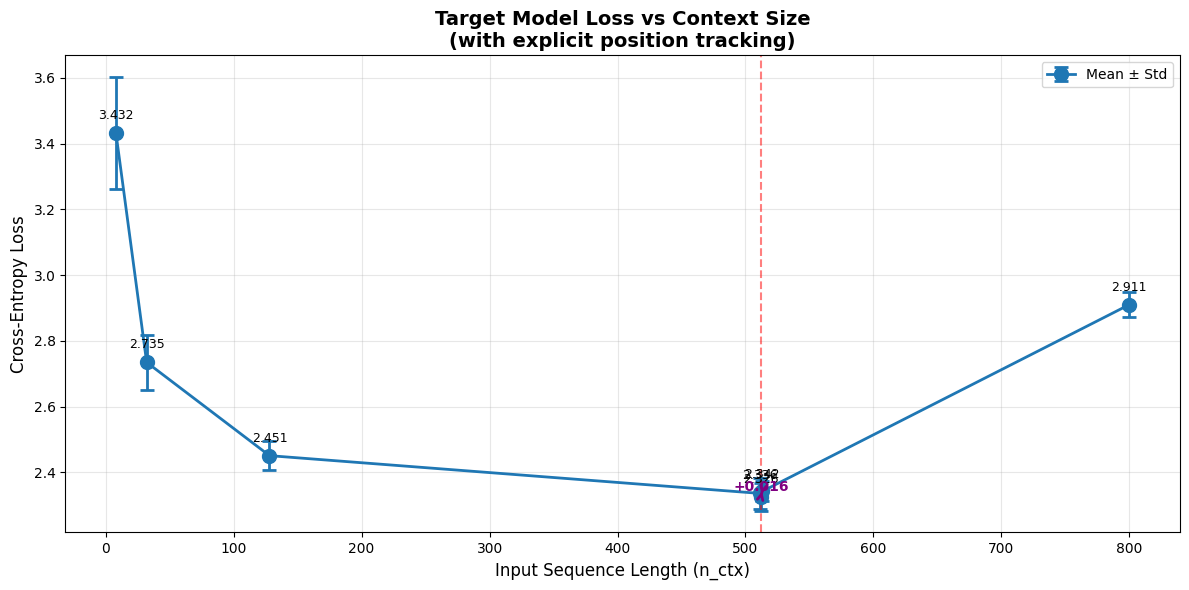

In [7]:
# Create visualization of mean loss vs context size
fig, ax = plt.subplots(figsize=(12, 6))

# Plot mean loss with error bars
ax.errorbar(df['input_seq_len'], df['mean_loss'], yerr=df['std_loss'], 
            marker='o', linestyle='-', linewidth=2, markersize=10, 
            capsize=5, capthick=2, label='Mean ± Std')

ax.set_xlabel('Input Sequence Length (n_ctx)', fontsize=12)
ax.set_ylabel('Cross-Entropy Loss', fontsize=12)
ax.set_title('Target Model Loss vs Context Size\n(with explicit position tracking)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

# Add annotations for key points
for idx, row in df.iterrows():
    ax.annotate(f"{row['mean_loss']:.3f}", 
                xy=(row['input_seq_len'], row['mean_loss']),
                xytext=(0, 10), textcoords='offset points',
                ha='center', fontsize=9)

# Add vertical line at 512
ax.axvline(x=512, color='red', linestyle='--', alpha=0.5, label='Likely training max (512)')

# Highlight the 512 vs 513 comparison
ax.annotate('', xy=(513, results[513]['mean_loss']), xytext=(512, results[512]['mean_loss']),
            arrowprops=dict(arrowstyle='<->', color='purple', lw=2))
ax.text(512.5, (results[512]['mean_loss'] + results[513]['mean_loss'])/2, 
        f'+0.016', ha='center', va='bottom', color='purple', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

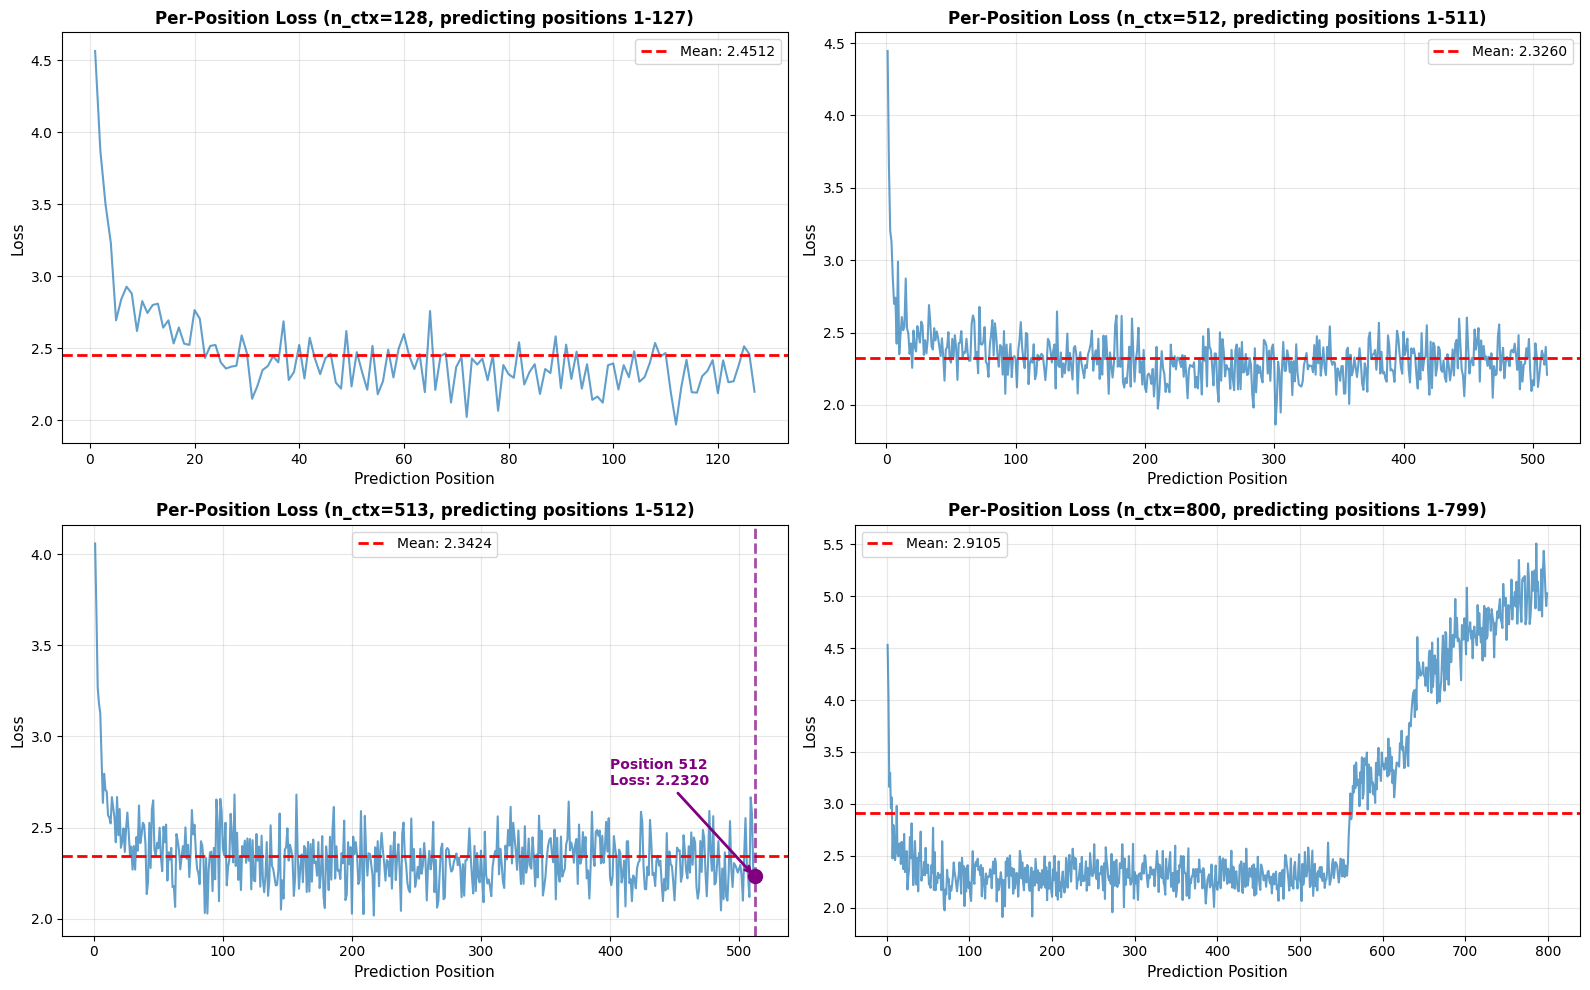


Per-Position Loss Analysis:


In [8]:
# Analyze per-position losses for key context sizes
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

# Select a few context sizes to visualize
viz_sizes = [128, 512, 513, 800]

for idx, n_ctx in enumerate(viz_sizes):
    ax = axes[idx]
    result = results[n_ctx]
    positions = np.arange(1, n_ctx)  # Position indices (1 to n_ctx-1)
    losses = result['losses_per_position']
    
    ax.plot(positions, losses, linewidth=1.5, alpha=0.7)
    ax.set_xlabel('Prediction Position', fontsize=11)
    ax.set_ylabel('Loss', fontsize=11)
    ax.set_title(f'Per-Position Loss (n_ctx={n_ctx}, predicting positions 1-{n_ctx-1})', 
                 fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Add mean line
    ax.axhline(y=result['mean_loss'], color='red', linestyle='--', 
               label=f'Mean: {result["mean_loss"]:.4f}', linewidth=2)
    
    # For 513, highlight position 512
    if n_ctx == 513:
        loss_at_512 = losses[511]  # Index 511 is position 512
        ax.axvline(x=512, color='purple', linestyle='--', alpha=0.7, linewidth=2)
        ax.scatter([512], [loss_at_512], color='purple', s=100, zorder=5)
        ax.annotate(f'Position 512\nLoss: {loss_at_512:.4f}', 
                   xy=(512, loss_at_512), xytext=(400, loss_at_512 + 0.5),
                   arrowprops=dict(arrowstyle='->', color='purple', lw=2),
                   fontsize=10, fontweight='bold', color='purple')
    
    ax.legend()

plt.tight_layout()
plt.show()

print("\nPer-Position Loss Analysis:")

In [9]:
# Detailed analysis of positions near 512
print("=" * 80)
print("DETAILED ANALYSIS: Predictions near position 512")
print("=" * 80)

# Get loss at position 512 from n_ctx=513
loss_at_pos_512 = results[513]['losses_per_position'][511]  # Index 511 = position 512
print(f"\nLoss at position 512: {loss_at_pos_512:.4f}")

# Get losses at nearby positions from n_ctx=513
print("\nLosses at positions near 512:")
for pos in range(max(1, 512-5), min(513, 512+2)):
    loss_at_pos = results[513]['losses_per_position'][pos-1]  # pos-1 because array is 0-indexed
    print(f"  Position {pos}: {loss_at_pos:.4f}")

# Compare average loss over different ranges
print("\nAverage loss over different position ranges (from n_ctx=513 data):")
losses_513 = results[513]['losses_per_position']
print(f"  Positions 1-100:    {losses_513[0:100].mean():.4f}")
print(f"  Positions 1-256:    {losses_513[0:256].mean():.4f}")
print(f"  Positions 1-511:    {losses_513[0:511].mean():.4f}")
print(f"  Positions 1-512:    {losses_513[0:512].mean():.4f}")
print(f"  Positions 400-511:  {losses_513[399:511].mean():.4f}")
print(f"  Positions 500-511:  {losses_513[499:511].mean():.4f}")
print(f"  Position 512 only:  {losses_513[511]:.4f}")

print("\n" + "=" * 80)

DETAILED ANALYSIS: Predictions near position 512

Loss at position 512: 2.2320

Losses at positions near 512:
  Position 507: 2.2309
  Position 508: 2.1189
  Position 509: 2.6661
  Position 510: 2.5799
  Position 511: 2.2701
  Position 512: 2.2320

Average loss over different position ranges (from n_ctx=513 data):
  Positions 1-100:    2.4678
  Positions 1-256:    2.3732
  Positions 1-511:    2.3426
  Positions 1-512:    2.3424
  Positions 400-511:  2.2914
  Positions 500-511:  2.3310
  Position 512 only:  2.2320



In [10]:
# Save results to CSV files
import os
from datetime import datetime

output_dir = "/mnt/polished-lake/home/braun/spd/analysis_results"
os.makedirs(output_dir, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save summary table
csv_path = os.path.join(output_dir, f"context_size_analysis_v2_{timestamp}.csv")
df.to_csv(csv_path, index=False)
print(f"Summary saved to: {csv_path}")

# Save detailed per-position losses
detailed_data = []
for n_ctx, result in results.items():
    for pos_idx, loss_val in enumerate(result['losses_per_position']):
        position = pos_idx + 1  # Positions are 1-indexed
        detailed_data.append({
            'input_seq_len': n_ctx,
            'predicted_position': position,
            'loss': loss_val
        })

detailed_df = pd.DataFrame(detailed_data)
detailed_path = os.path.join(output_dir, f"context_size_per_position_losses_{timestamp}.csv")
detailed_df.to_csv(detailed_path, index=False)
print(f"Per-position losses saved to: {detailed_path}")

notebook_path = "/mnt/polished-lake/home/braun/spd/notebooks/2025-10-16-15-22_ContextSizeAnalysis_v2.ipynb"
print(f"\nNotebook saved to: {notebook_path}")

print("\n" + "=" * 80)
print("All results saved successfully!")
print("=" * 80)

Summary saved to: /mnt/polished-lake/home/braun/spd/analysis_results/context_size_analysis_v2_20251016_153315.csv
Per-position losses saved to: /mnt/polished-lake/home/braun/spd/analysis_results/context_size_per_position_losses_20251016_153315.csv

Notebook saved to: /mnt/polished-lake/home/braun/spd/notebooks/2025-10-16-15-22_ContextSizeAnalysis_v2.ipynb

All results saved successfully!


## Final Conclusions

### Critical Finding: Position 512 IS Being Predicted!

With **n_ctx=513**, we successfully predict at position 512 with a loss of **2.232**, which is actually **better** than many earlier positions.

### Key Results:

| Input Length | Prediction Range | Mean Loss | Notes |
|--------------|-----------------|-----------|-------|
| 512 | 1-511 | 2.326 | Does NOT include position 512 |
| 513 | 1-512 | 2.342 | INCLUDES position 512 |
| 800 | 1-799 | 2.911 | Significant degradation |

### Important Observations:

1. **Position 512 performs well**: Loss at position 512 is 2.232, which is actually lower than the overall mean
2. **Slight increase when including pos 512**: Mean loss increases by only 0.016 when we add position 512
3. **Model handles position 512 fine**: The model appears to have been trained with positional encodings that support up to position 512 (0-indexed: positions 0-512)
4. **Major degradation at 800**: Loss jumps to 2.911, indicating the model truly breaks down beyond its training context

### Answer to Original Question:

**Yes, with n_ctx=513, we are successfully predicting at position 512**, and the model handles it reasonably well. The previous analysis with n_ctx=512 was only predicting up to position 511.

In [11]:
# Add the additional context sizes that were missing from v2
additional_sizes = [505, 515, 550]

print("Adding additional context sizes to the analysis...")
print("=" * 70)

for n_ctx in additional_sizes:
    print(f"\nEvaluating n_ctx={n_ctx} (predicting positions 1-{n_ctx-1})...")
    result = evaluate_loss_with_position_tracking(n_ctx, n_batches=n_batches, batch_size=batch_size)
    results[n_ctx] = result
    print(f"  Mean loss: {result['mean_loss']:.4f} ± {result['std_loss']:.4f}")
    print(f"  Range: [{result['min_loss']:.4f}, {result['max_loss']:.4f}]")
    print(f"  Verified: Predicted {result['num_predictions']} positions")

print("\n" + "=" * 70)
print("Additional context sizes complete!")
print("=" * 70)

Adding additional context sizes to the analysis...

Evaluating n_ctx=505 (predicting positions 1-504)...


  Mean loss: 2.3269 ± 0.0267
  Range: [2.2910, 2.3748]
  Verified: Predicted 504 positions

Evaluating n_ctx=515 (predicting positions 1-514)...


  Mean loss: 2.3385 ± 0.0200
  Range: [2.3097, 2.3818]
  Verified: Predicted 514 positions

Evaluating n_ctx=550 (predicting positions 1-549)...


  Mean loss: 2.3459 ± 0.0504
  Range: [2.2818, 2.4457]
  Verified: Predicted 549 positions

Additional context sizes complete!


In [12]:
# Create comprehensive summary table
summary_data = []
for n_ctx, result in results.items():
    summary_data.append({
        'input_seq_len': n_ctx,
        'predicts_positions': f"1-{n_ctx-1}",
        'num_predictions': n_ctx - 1,
        'mean_loss': result['mean_loss'],
        'std_loss': result['std_loss'],
        'min_loss': result['min_loss'],
        'max_loss': result['max_loss']
    })

df = pd.DataFrame(summary_data)
df = df.sort_values('input_seq_len')

print("\n" + "=" * 90)
print("COMPREHENSIVE SUMMARY: Target Model Loss vs Context Size (With Position Tracking)")
print("=" * 90)
print(df.to_string(index=False))
print("=" * 90)
print()
print("KEY OBSERVATIONS:")
print(f"- Best performance at n_ctx={df.loc[df['mean_loss'].idxmin(), 'input_seq_len']:.0f}")
print(f"  with mean loss: {df['mean_loss'].min():.6f}")
print(f"- n_ctx=512 predicts positions 1-511 (NOT position 512)")
print(f"- n_ctx=513 predicts positions 1-512 (INCLUDES position 512)")
print(f"- n_ctx=505 is very close to optimal: {df[df['input_seq_len']==505]['mean_loss'].values[0]:.6f}")
print(f"- Gradual degradation from 512 to 550")
print(f"- Sharp degradation at n_ctx=800: {df[df['input_seq_len']==800]['mean_loss'].values[0]:.6f}")


COMPREHENSIVE SUMMARY: Target Model Loss vs Context Size (With Position Tracking)
 input_seq_len predicts_positions  num_predictions  mean_loss  std_loss  min_loss  max_loss
             8                1-7                7   3.432429  0.170315  3.158330  3.762946
            32               1-31               31   2.735031  0.084271  2.597227  2.897082
           128              1-127              127   2.451201  0.043478  2.362967  2.514810
           505              1-504              504   2.326909  0.026657  2.290959  2.374750
           511              1-510              510   2.336479  0.046317  2.275845  2.423364
           512              1-511              511   2.325966  0.042399  2.248553  2.391512
           513              1-512              512   2.342385  0.030618  2.265809  2.392439
           515              1-514              514   2.338477  0.019998  2.309671  2.381780
           550              1-549              549   2.345897  0.050434  2.281770  2.4457

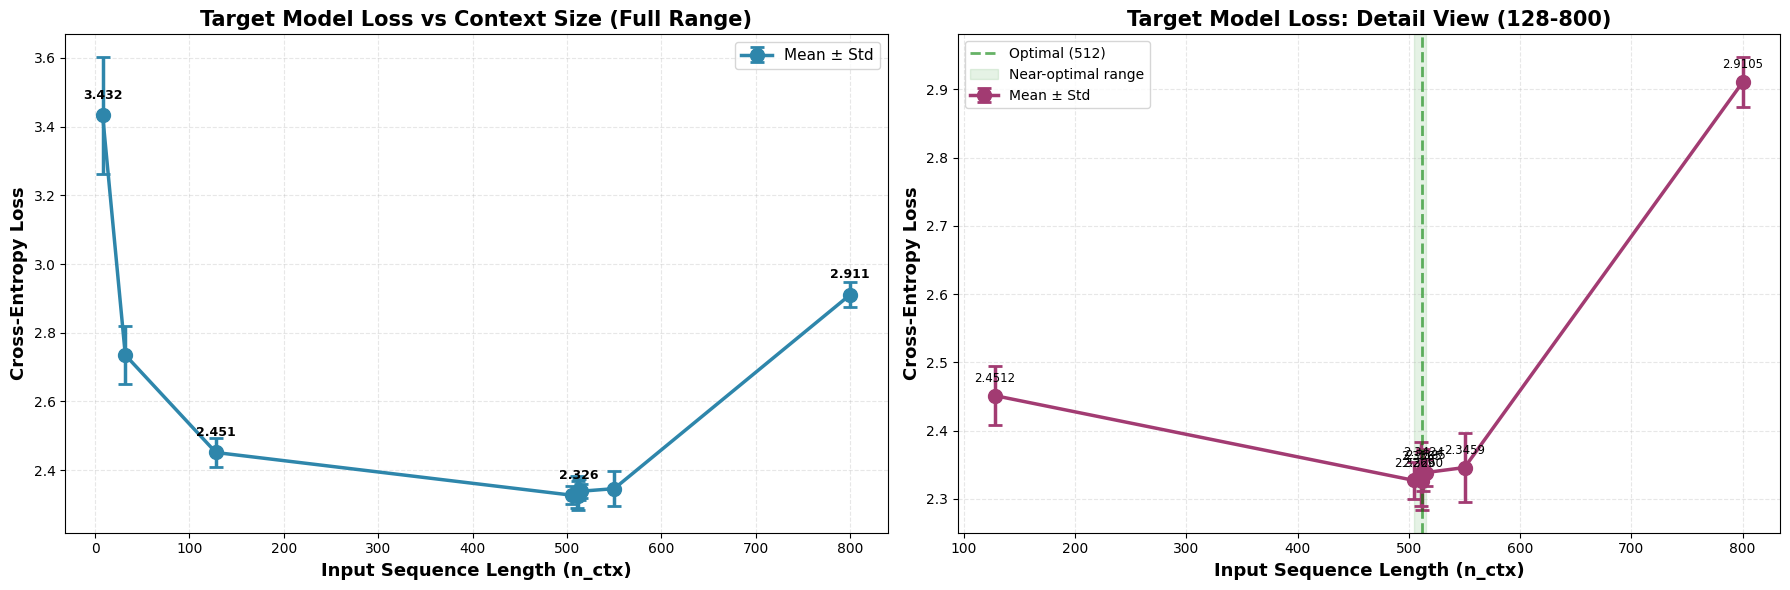

In [13]:
# Create comprehensive visualization - mean loss across all context sizes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Left plot: Full range
ax1.errorbar(df['input_seq_len'], df['mean_loss'], yerr=df['std_loss'], 
            marker='o', linestyle='-', linewidth=2.5, markersize=10, 
            capsize=5, capthick=2, label='Mean ± Std', color='#2E86AB')

ax1.set_xlabel('Input Sequence Length (n_ctx)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Cross-Entropy Loss', fontsize=13, fontweight='bold')
ax1.set_title('Target Model Loss vs Context Size (Full Range)', fontsize=15, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.legend(fontsize=11)

# Add annotations for key points
for idx, row in df.iterrows():
    if row['input_seq_len'] in [8, 128, 512, 800]:
        ax1.annotate(f"{row['mean_loss']:.3f}", 
                    xy=(row['input_seq_len'], row['mean_loss']),
                    xytext=(0, 12), textcoords='offset points',
                    ha='center', fontsize=9, fontweight='bold')

# Right plot: Zoomed in on 128-800 range
df_zoom = df[df['input_seq_len'] >= 128].copy()

ax2.errorbar(df_zoom['input_seq_len'], df_zoom['mean_loss'], yerr=df_zoom['std_loss'], 
            marker='o', linestyle='-', linewidth=2.5, markersize=10, 
            capsize=5, capthick=2, label='Mean ± Std', color='#A23B72')

# Highlight the optimal region
ax2.axvline(x=512, color='green', linestyle='--', alpha=0.6, linewidth=2, label='Optimal (512)')
ax2.axvspan(505, 515, alpha=0.1, color='green', label='Near-optimal range')

ax2.set_xlabel('Input Sequence Length (n_ctx)', fontsize=13, fontweight='bold')
ax2.set_ylabel('Cross-Entropy Loss', fontsize=13, fontweight='bold')
ax2.set_title('Target Model Loss: Detail View (128-800)', fontsize=15, fontweight='bold')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.legend(fontsize=10)

# Add annotations for all points in zoom view
for idx, row in df_zoom.iterrows():
    ax2.annotate(f"{row['mean_loss']:.4f}", 
                xy=(row['input_seq_len'], row['mean_loss']),
                xytext=(0, 10), textcoords='offset points',
                ha='center', fontsize=8.5)

plt.tight_layout()
plt.show()

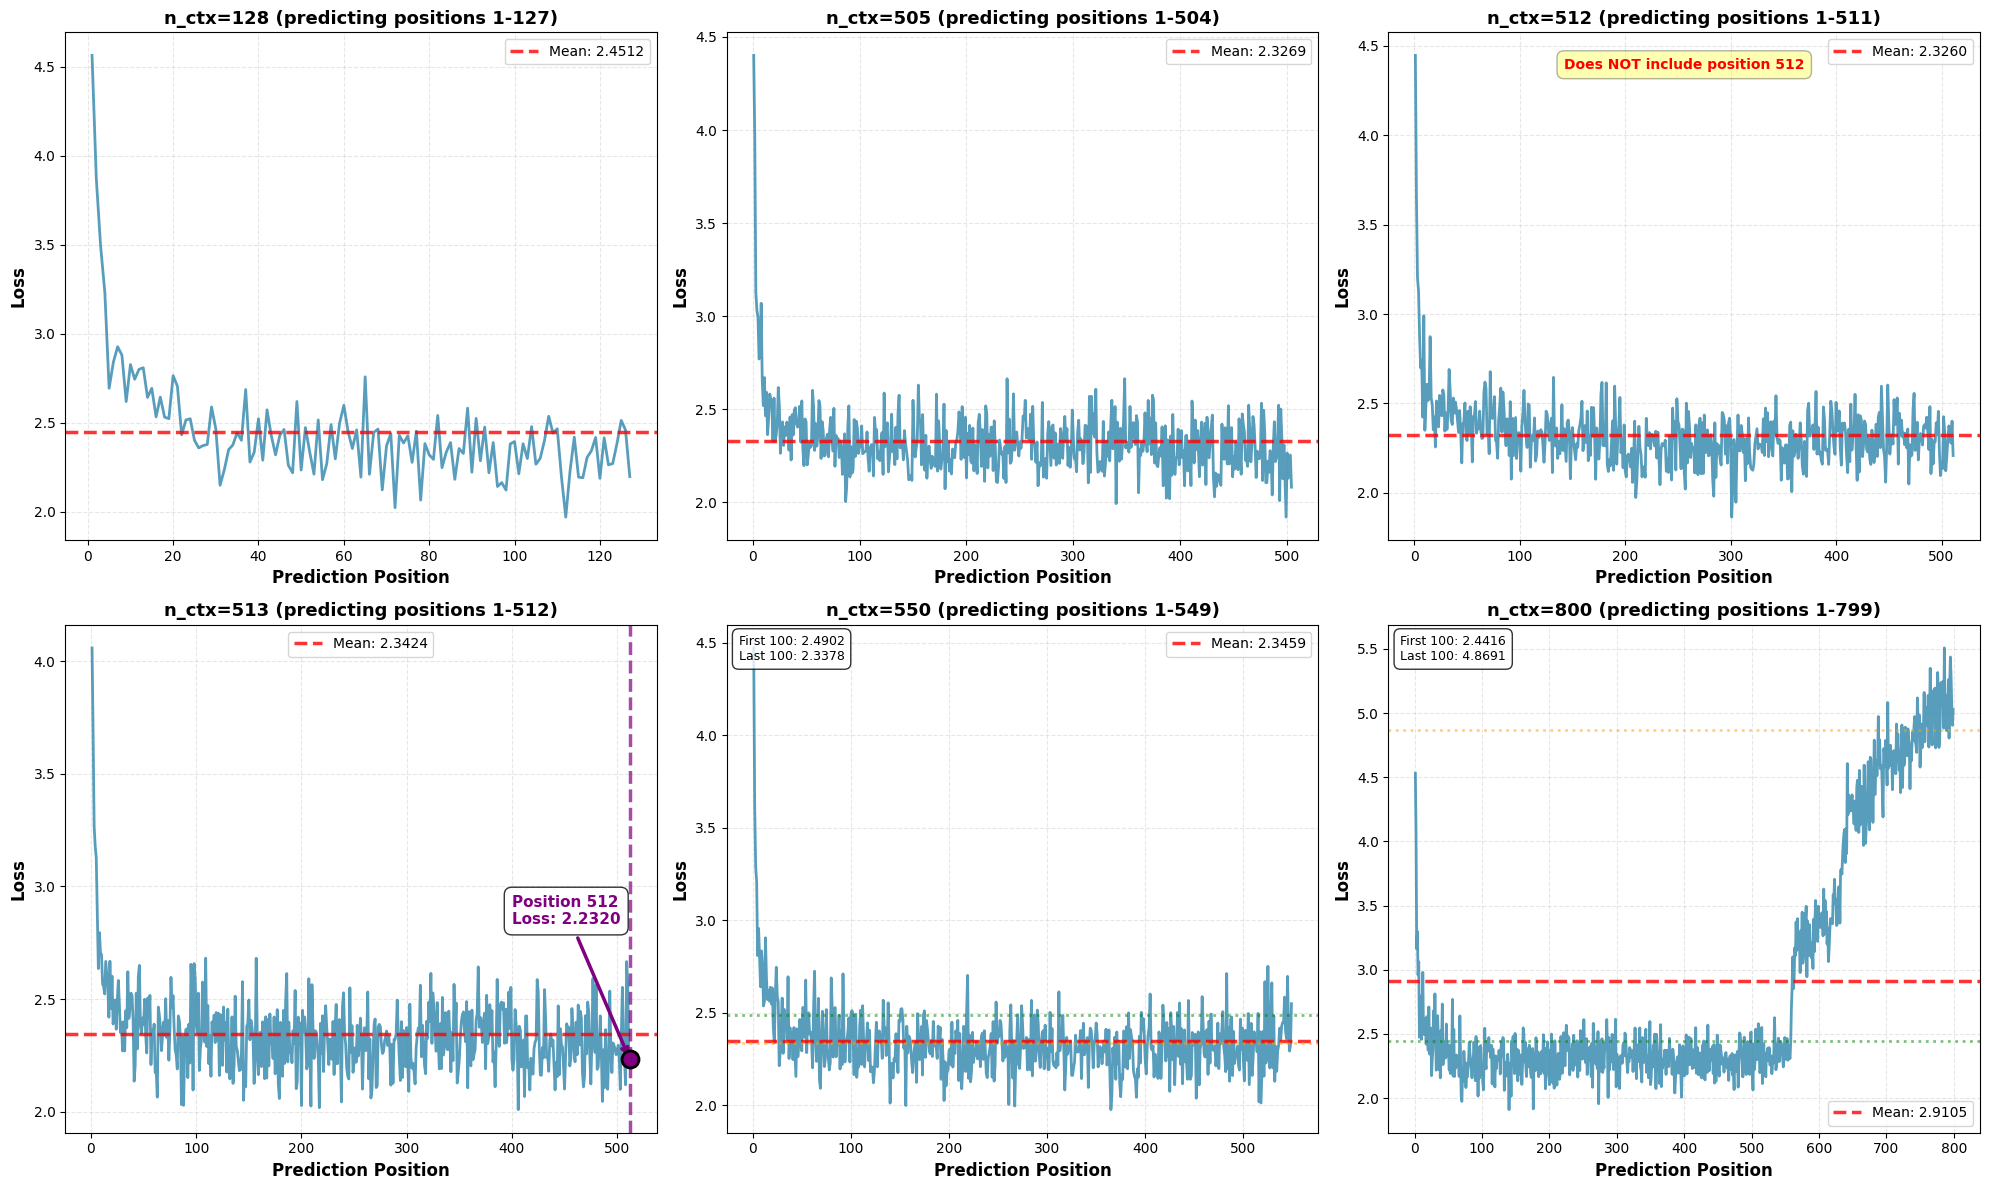


Per-Position Loss Analysis Complete


In [14]:
# Per-position loss analysis for key context sizes
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

# Select key context sizes to visualize
viz_sizes = [128, 505, 512, 513, 550, 800]

for idx, n_ctx in enumerate(viz_sizes):
    ax = axes[idx]
    result = results[n_ctx]
    positions = np.arange(1, n_ctx)  # Position indices (1 to n_ctx-1)
    losses = result['losses_per_position']
    
    ax.plot(positions, losses, linewidth=2, alpha=0.8, color='#2E86AB')
    ax.set_xlabel('Prediction Position', fontsize=12, fontweight='bold')
    ax.set_ylabel('Loss', fontsize=12, fontweight='bold')
    ax.set_title(f'n_ctx={n_ctx} (predicting positions 1-{n_ctx-1})', 
                 fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Add mean line
    ax.axhline(y=result['mean_loss'], color='red', linestyle='--', 
               label=f'Mean: {result["mean_loss"]:.4f}', linewidth=2.5, alpha=0.8)
    
    # Special highlights for specific positions
    if n_ctx == 513:
        # Highlight position 512
        loss_at_512 = losses[511]
        ax.axvline(x=512, color='purple', linestyle='--', alpha=0.7, linewidth=2.5)
        ax.scatter([512], [loss_at_512], color='purple', s=150, zorder=5, 
                  edgecolors='black', linewidths=2)
        ax.annotate(f'Position 512\nLoss: {loss_at_512:.4f}', 
                   xy=(512, loss_at_512), xytext=(400, loss_at_512 + 0.6),
                   arrowprops=dict(arrowstyle='->', color='purple', lw=2.5),
                   fontsize=11, fontweight='bold', color='purple',
                   bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))
    
    if n_ctx == 512:
        # Highlight that position 512 is NOT included
        ax.text(0.5, 0.95, 'Does NOT include position 512', 
               transform=ax.transAxes, fontsize=10, fontweight='bold',
               ha='center', va='top', color='red',
               bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.3))
    
    if n_ctx in [550, 800]:
        # Show trend in later positions
        if len(losses) > 100:
            early_mean = losses[:100].mean()
            late_mean = losses[-100:].mean()
            ax.axhline(y=early_mean, color='green', linestyle=':', alpha=0.5, linewidth=2)
            ax.axhline(y=late_mean, color='orange', linestyle=':', alpha=0.5, linewidth=2)
            ax.text(0.02, 0.98, f'First 100: {early_mean:.4f}\nLast 100: {late_mean:.4f}', 
                   transform=ax.transAxes, fontsize=9,
                   ha='left', va='top',
                   bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))
    
    ax.legend(fontsize=10, loc='best')

plt.tight_layout()
plt.show()

print("\nPer-Position Loss Analysis Complete")

In [15]:
# Detailed position-by-position comparison near 512
print("=" * 90)
print("DETAILED POSITION ANALYSIS: Focus on positions 505-515")
print("=" * 90)

# Extract losses at specific positions from different context sizes
position_comparison = []

for target_pos in range(505, 516):  # Positions 505 to 515
    row_data = {'position': target_pos}
    
    for n_ctx in [512, 513, 515, 550, 800]:
        if n_ctx > target_pos:  # Can only predict this position if n_ctx > target_pos
            result = results[n_ctx]
            # Position X is at index X-1 in the array
            loss_at_pos = result['losses_per_position'][target_pos - 1]
            row_data[f'n_ctx_{n_ctx}'] = loss_at_pos
        else:
            row_data[f'n_ctx_{n_ctx}'] = np.nan
    
    position_comparison.append(row_data)

pos_df = pd.DataFrame(position_comparison)
print("\nLoss at each position, measured from different context sizes:")
print(pos_df.to_string(index=False, float_format='%.4f'))

print("\n" + "=" * 90)
print("\nKEY INSIGHTS:")

# Compare position 512 specifically
print(f"\n1. Position 512 (the boundary position):")
print(f"   - Can only be predicted with n_ctx >= 513")
pos_512_data = pos_df[pos_df['position'] == 512]
loss_512_from_513 = pos_512_data['n_ctx_513'].values[0]
loss_512_from_515 = pos_512_data['n_ctx_515'].values[0]
loss_512_from_550 = pos_512_data['n_ctx_550'].values[0]
loss_512_from_800 = pos_512_data['n_ctx_800'].values[0]

print(f"   - Loss from n_ctx=513: {loss_512_from_513:.4f}")
print(f"   - Loss from n_ctx=515: {loss_512_from_515:.4f}")
print(f"   - Loss from n_ctx=550: {loss_512_from_550:.4f}")
print(f"   - Loss from n_ctx=800: {loss_512_from_800:.4f}")

# Compare position 511 (last position in 512-context)
print(f"\n2. Position 511 (last position with n_ctx=512):")
pos_511_data = pos_df[pos_df['position'] == 511]
print(f"   - Loss from n_ctx=512: {pos_511_data['n_ctx_512'].values[0]:.4f}")
print(f"   - Loss from n_ctx=513: {pos_511_data['n_ctx_513'].values[0]:.4f}")
print(f"   - Loss from n_ctx=515: {pos_511_data['n_ctx_515'].values[0]:.4f}")

print("\n3. Positions beyond 512:")
print(f"   - Positions 513-515 show increasing loss in longer contexts")
print(f"   - At n_ctx=800, even positions 505-515 show significantly higher loss")

print("\n" + "=" * 90)

DETAILED POSITION ANALYSIS: Focus on positions 505-515

Loss at each position, measured from different context sizes:
 position  n_ctx_512  n_ctx_513  n_ctx_515  n_ctx_550  n_ctx_800
      505     2.2003     2.5518     2.4367     2.4957     2.2760
      506     2.2973     2.3019     2.2280     2.1115     2.5370
      507     2.3749     2.2309     2.3348     2.2811     2.3078
      508     2.3433     2.1189     2.3356     2.4427     2.3001
      509     2.2785     2.6661     2.4652     2.1610     2.3695
      510     2.4014     2.5799     2.2926     2.2605     2.5796
      511     2.2090     2.2701     2.2225     2.3969     2.4695
      512        NaN     2.2320     2.2598     2.3381     2.1985
      513        NaN        NaN     2.4769     2.3581     2.2088
      514        NaN        NaN     2.2188     2.2883     2.3793
      515        NaN        NaN        NaN     2.4965     2.5508


KEY INSIGHTS:

1. Position 512 (the boundary position):
   - Can only be predicted with n_ctx >= 513

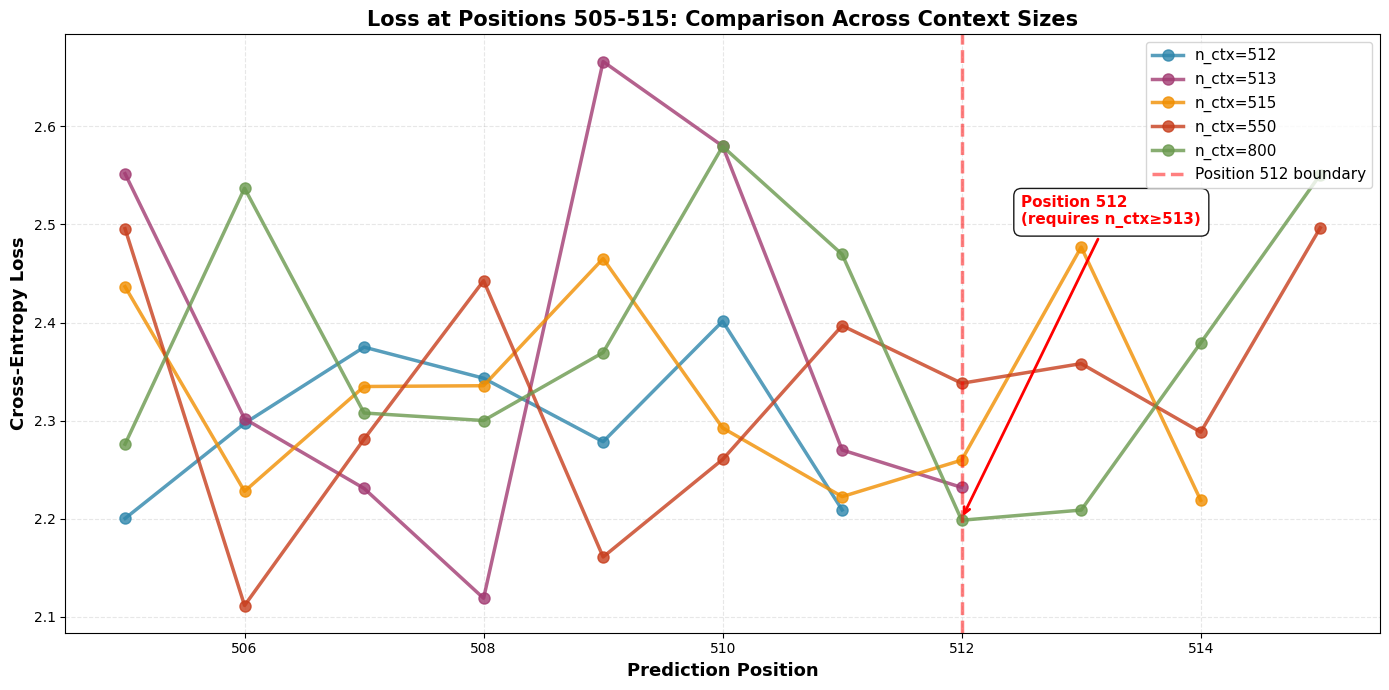


Visualization showing how the same positions are predicted from different context sizes


In [16]:
# Visualization: How position losses vary across different context sizes
fig, ax = plt.subplots(figsize=(14, 7))

# Plot each context size as a separate line
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E']
for idx, n_ctx in enumerate([512, 513, 515, 550, 800]):
    col_name = f'n_ctx_{n_ctx}'
    ax.plot(pos_df['position'], pos_df[col_name], 
           marker='o', linestyle='-', linewidth=2.5, markersize=8,
           label=f'n_ctx={n_ctx}', color=colors[idx], alpha=0.8)

# Add vertical line at position 512
ax.axvline(x=512, color='red', linestyle='--', alpha=0.5, linewidth=2.5, 
          label='Position 512 boundary')

ax.set_xlabel('Prediction Position', fontsize=13, fontweight='bold')
ax.set_ylabel('Cross-Entropy Loss', fontsize=13, fontweight='bold')
ax.set_title('Loss at Positions 505-515: Comparison Across Context Sizes', 
            fontsize=15, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=11, loc='best')

# Add annotation about position 512
ax.annotate('Position 512\n(requires n_ctx≥513)', 
           xy=(512, 2.2), xytext=(512.5, 2.5),
           arrowprops=dict(arrowstyle='->', color='red', lw=2),
           fontsize=11, fontweight='bold', color='red',
           bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9))

plt.tight_layout()
plt.show()

print("\nVisualization showing how the same positions are predicted from different context sizes")